## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
# Import our libraries.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
# Ensure we get the same answers on quizzes as on the website
random.seed(42)

`1.` Read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
100 * (df.query('converted == 1').user_id.nunique() / df.user_id.nunique())

12.104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
print( len(df[( ~(df['group'] == 'treatment') == (df['landing_page'] == 'new_page') )]) )

# Double check using a different method:
treatment_oldpage = len(df.query(" (group == 'treatment') & (landing_page == 'old_page') ") )
control_newpage = len(df.query(" (group == 'control') & (landing_page == 'new_page') ") )
print(treatment_oldpage+control_newpage)

3893
3893


f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


There appear to be no missing values. Let us double check...

In [8]:
for column in df.columns:     
    print(column+":", "Missing values in this column?",  any(df[column].isnull()))

user_id: Missing values in this column? False
timestamp: Missing values in this column? False
group: Missing values in this column? False
landing_page: Missing values in this column? False
converted: Missing values in this column? False


In [9]:
df_original = df.copy() # Keep a copy in case we need it later

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Use the answer to the **Quiz 2** to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
df2 = (df.query(" ~((group == 'treatment') & (landing_page == 'old_page')) ") )
df2 = (df2.query(" ~((group == 'control') & (landing_page == 'new_page')) ") )

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
# See both rows
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.drop(index = 2893, inplace = True)
# Check that the duplicate is gone:
df2.user_id[df2.user_id.duplicated()]

Series([], Name: user_id, dtype: int64)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.query("converted == 1").user_id.nunique() / df2.user_id.nunique()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query("(converted == 1) & (group == 'control')").user_id.nunique() / df2.query("group == 'control'").user_id.nunique()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query("(converted == 1) & (group == 'treatment')").user_id.nunique() / df2.query("group == 'treatment'").user_id.nunique()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
df2.query("landing_page == 'new_page'").user_id.nunique() / df2.user_id.nunique()

0.5000619442226688

Let us also calculate the difference in probabilities between the treatment group and the control group:

In [21]:
prob_converted_given_control = df2.query("(converted == 1) & (group == 'control')").user_id.nunique() / df2.query("group == 'control'").user_id.nunique()
prob_converted_given_treated = df2.query("(converted == 1) & (group == 'treatment')").user_id.nunique() / df2.query("group == 'treatment'").user_id.nunique()
actual_diff = prob_converted_given_treated - prob_converted_given_control
print(actual_diff)

-0.0015782389853555567


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**There is not sufficient evidence to say that the new treatment page leads to more conversions.** 

First let us note that, given that an individual was in the treatment group, the probability of converting (0.119) is almost exactly the same as the probability of converting given that an individual was in the control group (0.120); this is also almost exactly the probability of converting regardless of which page was received (0.120). These differences are not practically significant.

Without calculating the p-value associated with these probabilities (or the confidence intervals within which the values probabilities lie), it is not possible to state whether the small differences are statistically significant.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5% ($\alpha = 0.05$), what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$\alpha = 0.05$

Null hypothesis:
$$p_{new} - p_{old} = 0 $$

Alternative hypothesis:
$$p_{new} - p_{old} > 0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
# **converted** success rate regardless of page
p_new = df2.query("converted == 1").user_id.nunique() / len(df2)
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
# **converted** success rate regardless of page, i.e., same as above
p_old = df2.query("converted == 1").user_id.nunique() / len(df2)
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
n_new = df2.query("group == 'treatment'").user_id.nunique()
print(n_new)
# This should be the same as (because we have already cleaned the data to ensure that it is):
n_new = df2.query("landing_page == 'new_page'").user_id.nunique()
print(n_new)


145310
145310


d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
n_old = df2.query("group == 'control'").user_id.nunique()
print(n_old)
n_old = df2.query("landing_page == 'old_page'").user_id.nunique()
print(n_old)

145274
145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.choice([0,1], n_new, p =(1-p_new, p_new))

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.choice([0,1], n_old, p =(1-p_old, p_old))

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
new_page_converted.mean() - old_page_converted.mean()

-0.0018881417255610655

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([0,1], n_new, p =(1-p_new, p_new))
    old_page_converted = np.random.choice([0,1], n_old, p =(1-p_old, p_old))
    p_diffs.append( new_page_converted.mean() - old_page_converted.mean() )

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

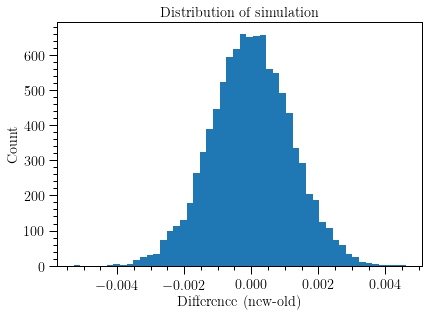

In [30]:
# Convert to numpy array
p_diffs = np.array(p_diffs)

# Plot sampling distribution
plt.hist(p_diffs, bins = 50);
plt.xlabel('Difference (new-old)')
plt.ylabel('Count')
plt.title('Distribution of simulation');

**This appears to be normally distributed, as expected.**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

0.9084

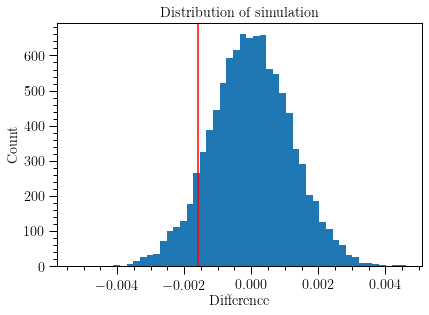

In [31]:
actual_diff = -0.0015782389853555567
# Plot sampling distribution
plt.hist(p_diffs, bins = 50);
plt.axvline(actual_diff, color = 'red');
plt.xlabel('Difference ')
plt.ylabel('Count')
plt.title('Distribution of simulation');

# Compute p-value
(p_diffs > actual_diff).mean()

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

This is the probability that the observed difference in ab_data.csv is due to chance. This is called the p-value. As this value is much larger than 0.05, there is no evidence to reject the null hypothesis. (We have no reason to believe the difference in the converted rates is due to anything other than chance.)

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

In [33]:
count_new = df2.query("(converted == 1) & (group == 'treatment')").user_id.nunique()
count_new

17264

In [34]:
count_old = df2.query("(converted == 1) & (group == 'control')").user_id.nunique()
count_old

17489

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [35]:
count_old 

17489

In [36]:
from statsmodels.stats.proportion import proportions_ztest
zstat, pval = proportions_ztest( [count_old, count_new] , [n_old, n_new] )
print('Z-value: {0:0.3f}'.format(zstat))
print('Raw p-value: {0:0.3f}'.format(pval))
print('Correct p-value: {0:0.3f}'.format(1 - pval/2)) # The reason for 1 - pval/2 is given below. 

Z-value: 1.311
Raw p-value: 0.190
Correct p-value: 0.905


<a id='2m'></a>

Note that I have subtracted the "raw p-value" from 1 and divided by two to obtain the appropriate p-value because my alterative hypothesis is $$p_{new} - p_{old} > 0 $$ and not $$p_{old} - p_{new} \neq 0. $$ Please see the answer to Part [III e.](#3e) for more detail.

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The p-value is greater than 0.05; the difference between the conversion rates is not statistically significant. The p-value does agree with that computed previously (0.905 $\approx$ 0.908) as long as the raw p-value given by proportions_ztest is converted to the p-value that we are interested in. 

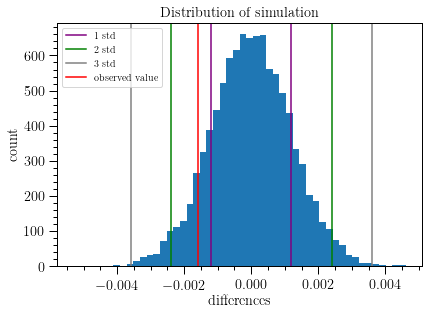

In [37]:
# Visualising the standard deviations
# Reference: https://knowledge.udacity.com/questions/497849

standard_deviation = np.std(p_diffs)
std1_low = 0 - standard_deviation*1
std1_high = 0 + standard_deviation*1
std2_low = 0 - standard_deviation*2
std2_high = 0 + standard_deviation*2
std3_low = 0 - standard_deviation*3
std3_high = 0 + standard_deviation*3

# visualizing
plt.hist(p_diffs, bins=50);
plt.axvline(x=std1_low, color='purple', label='1 std');
plt.axvline(x=std1_high, color='purple');
plt.axvline(x=std2_low, color='green', label='2 std');
plt.axvline(x=std2_high, color='green');
plt.axvline(x=std3_low, color='grey', label='3 std');
plt.axvline(x=std3_high, color='grey');
plt.axvline(actual_diff, color = 'red', label = 'observed value');
plt.title('Distribution of simulation');
plt.xlabel('differences');
plt.ylabel('count')
plt.legend();

As we can see from the above graph, the observed value (red) lies between 1 standard deviation (purple) to 2 standard deviations (green) from the zero point. It is closer to the 1 standard deviation line. This is in agreement with the value calculated by the proportions_ztest of 1.311. Both of these tell us that we do not have good reason to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [38]:
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2['intercept'] = 1
df2.head(1)

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [39]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 Jul 2021   Pseudo R-squ.:               8.077e-06
Time:                        08:16:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

<a id='3e'></a>
The p-value associated with **ab_page** is 0.190. (Note that this p-value is equal to the p-value labelled "Raw p-value" in Part [II m.](#2m) above.)

It differs from the value we found in Part II because the null & alternative hypotheses are different:

In Part II,

Null hypothesis:        $$p_{new} - p_{old} = 0, $$

Alternative hypothesis: $$p_{new} - p_{old} > 0. $$

Whereas, here, the null hypothesis is the same but the alternative hypothesis is

$$p_{new} - p_{old} \neq 0 $$.

The difference is that there is no directional component to this alternative hypothesis, i.e., $p_{new}$ could be bigger than or smaller than $p_{old}$. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Advantages:**
1. Adding additional factors allows us to determine the relative impact of different factors on the outcome.

2. Adding additional factors would allows to find any unexpected outliers, e.g. we might find that one factor does not have any impact on the outcome although we expected it to.

**Disadvantages:**
1. The additional factors may be correlated with the original factor (or with each other) leading to coefficients being flipped.

2. Outliers can have a disproportionate impact.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns. Provide the statistical output as well as a written response to answer this question.

In [41]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [42]:
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [43]:
print(df_new.country.unique())
df_new[['UK', 'US', 'CA']] = pd.get_dummies(df_new['country'])
df_new['intercept'] = 1

['UK' 'US' 'CA']


To create matrices that are full rank, we need to drop one of the columns when fitting our dummy variables. Let us drop 'US', so that the USA will be our baseline. 

In [44]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'CA']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 12 Jul 2021   Pseudo R-squ.:               1.521e-05
Time:                        08:16:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
UK            -0.0507      0.028     -1.786      0.074      -0.106       0.005
CA            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

The negative coefficients for UK and CA (Canada) suggest that there are worse outcomes (i.e., $p_{new} < p_{old} $) for these compared to the US, **but the high p-values ($>$0.05) mean that these results are not statistically significant.**

Also, the overlapping confidence intervals for the UK and CA mean that there is no significant difference between these countries. 

So, the company should stay with the old_pages as there is not enough evidence that the new_pages are effective.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [45]:
# Additional columns needed for higher order terms:
df_new['ab_page_UK'] = df_new['ab_page']*df_new['UK']
df_new['ab_page_US'] = df_new['ab_page']*df_new['US']
df_new['ab_page_CA'] = df_new['ab_page']*df_new['CA']

To create matrices that are full rank, we need to drop one of the columns when fitting our dummy variables. 
Let us drop 'US' & 'ab_page_US' so that the US will be our baseline. 

In [46]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'CA', 'ab_page_UK', 'ab_page_CA']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 12 Jul 2021   Pseudo R-squ.:               3.482e-05
Time:                        08:16:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
UK            -0.0118      0.040     -0.296      0.767      -0.090       0.066
CA             0.0057      0.019      0.306      0.760      -0.031       0.043
ab_page_UK    -0.0783      0.057     -1.378      0.168      -0.190       0.033
ab_page_CA    -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

The p-values are higher than 0.05, so the coefficients are not statistically significant.

Let us double check by performing the logistic regression again but, this time, dropping 'CA' & 'ab_page_CA' so that Canada will be our baseline. 

In [47]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'ab_page_UK', 'ab_page_US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 12 Jul 2021   Pseudo R-squ.:               3.482e-05
Time:                        08:16:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page_UK    -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_page_US     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

Again, all the p-values are higher than 0.05, so the coefficients are not statistically significant.

# Conclusion 
**So, the final summary is that the company should stay with the old_pages as there is not enough evidence that the new_pages are effective.** The company should also consider running the experiment for a longer time as more data can lead to a statistically significant result being obtained (although the results may still not be practically significant.)